In [95]:
!pip install ucimlrepo

In [96]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

rice = fetch_ucirepo(id=545)
rice

{'data': {'ids': None,
  'features':        Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
  0     15231  525.578979         229.749878          85.093788      0.928882   
  1     14656  494.311005         206.020065          91.730972      0.895405   
  2     14634  501.122009         214.106781          87.768288      0.912118   
  3     13176  458.342987         193.337387          87.448395      0.891861   
  4     14688  507.166992         211.743378          89.312454      0.906691   
  ...     ...         ...                ...                ...           ...   
  3805  11441  415.858002         170.486771          85.756592      0.864280   
  3806  11625  421.390015         167.714798          89.462570      0.845850   
  3807  12437  442.498993         183.572922          86.801979      0.881144   
  3808   9882  392.296997         161.193985          78.210480      0.874406   
  3809  11434  404.709992         161.079269          90.868195      0.825

In [97]:
X = rice.data.features
y = rice.data.targets

#видим, что у нас бин классификация
y['Class'].unique()

array(['Cammeo', 'Osmancik'], dtype=object)

In [98]:
import numpy as np

In [99]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

X = np.asarray(X, dtype=np.float32)
y = np.asarray(y).ravel()

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Форма данных: {X_scaled.shape}")
print(f"Классы: {le.classes_}")

Форма данных: (3810, 7)
Классы: ['Cammeo' 'Osmancik']


In [100]:
from sklearn.model_selection import train_test_split
import torch

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

In [101]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, init_weights=None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

        if init_weights is not None:
            if isinstance(init_weights, torch.Tensor) and init_weights.shape == self.fc1.weight.shape:
                with torch.no_grad():
                    self.fc1.weight = nn.Parameter(init_weights)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [102]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_mlp(model, X_train, y_train, epochs=2000, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in tqdm(range(epochs), desc="Training MLP"):
        model.train()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    plt.plot(range(epochs), losses, label="MLP Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f"Final Loss: {losses[-1]}")

    return losses

In [103]:
import torch.optim as optim

input_size = X_train.shape[1]
model = MLP(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training MLP: 100%|██████████| 2000/2000 [00:18<00:00, 109.49it/s]


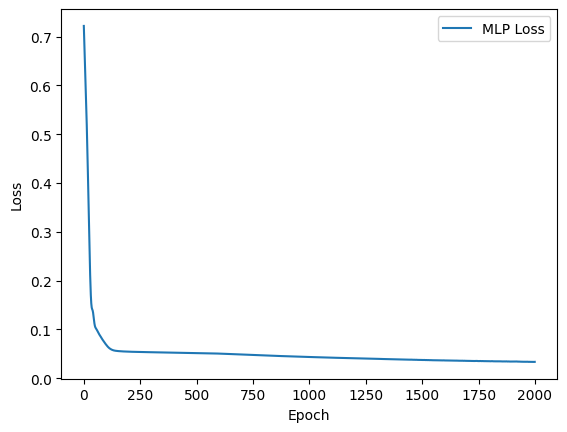

Final Loss: 0.03369325026869774


In [104]:
input_size = X_train.shape[1]
model = MLP(input_size)

losses = train_mlp(model, X_train, y_train)

In [106]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

n = 10
print([round(float(_[0]), 2) for _ in y_test_pred[:n]])
print([round(float(_[0]), 2) for _ in y_test[:n]])

Test Loss: 0.0666
[1.0, 0.97, 0.95, 0.11, 0.96, 0.24, 0.99, -0.06, 0.01, 0.1]
[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


In [107]:
import torch.nn.functional as F

class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))
        self.v_bias = nn.Parameter(torch.zeros(visible_units))

    def forward(self, v):
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        h_sample = torch.bernoulli(h_prob)
        v_reconstructed_prob = torch.sigmoid(F.linear(h_sample, self.W.t(), self.v_bias))
        return h_prob, v_reconstructed_prob

    def sample_hidden(self, v):
        return torch.sigmoid(F.linear(v, self.W, self.h_bias))

In [108]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_rbm(rbm, data, epochs=10, lr=0.01):
    optimizer = optim.SGD(rbm.parameters(), lr=lr)
    losses = []
    pbar = tqdm(range(epochs), desc="Training RBM")

    for epoch in pbar:
        epoch_loss = 0
        for batch in data:
            v = batch
            h_prob, v_reconstructed = rbm(v)
            loss = torch.mean((v - v_reconstructed) ** 2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(data)
        losses.append(avg_loss)
        pbar.set_description(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    plt.plot(losses, label="RBM Training Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('RBM Loss Decay')
    plt.legend()
    plt.show()

    return rbm, losses

Epoch 10/10, Loss: 1.2641: 100%|██████████| 10/10 [00:00<00:00, 68.82it/s]


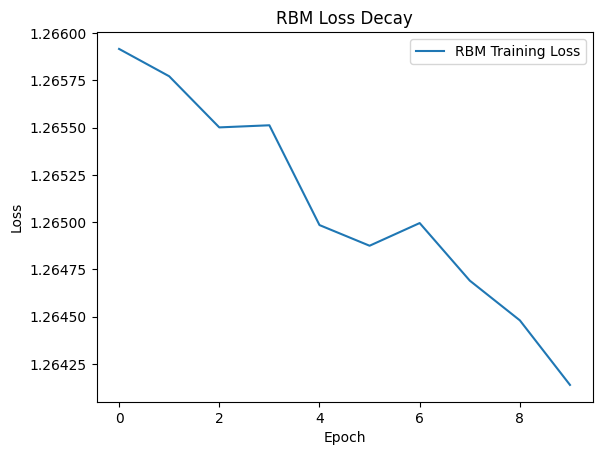

In [109]:
visible_units = X_train.shape[1]
hidden_units = 64

rbm = RBM(visible_units, hidden_units)
rbm, losses_rbm = train_rbm(rbm, [X_train], lr=0.001)

Training MLP: 100%|██████████| 2000/2000 [00:08<00:00, 234.48it/s]


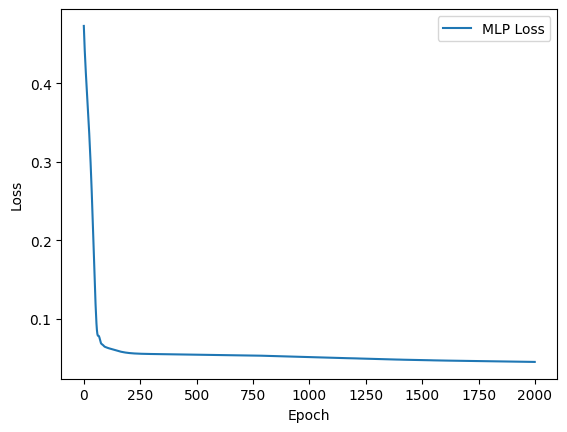

Final Loss: 0.044830143451690674


In [110]:
input_size = X_train.shape[1]
rbm_hidden_weights = rbm.W
model_pretr = MLP(input_size=visible_units, init_weights=rbm_hidden_weights)

losses_pretr = train_mlp(model_pretr, X_train, y_train)

In [111]:
model.eval()
with torch.no_grad():
    y_test_pred = model_pretr(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

n = 10
print([round(float(_[0]), 2) for _ in y_test_pred[:n]])
print([round(float(_[0]), 2) for _ in y_test[:n]])

Test Loss: 0.0553
[0.6, 0.99, 0.97, 0.15, 1.01, 0.22, 1.0, 0.07, -0.0, 0.5]
[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


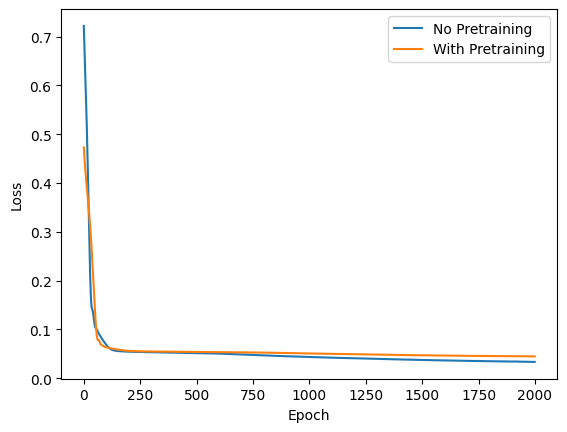

In [112]:
plt.plot(losses, label="No Pretraining")
plt.plot(losses_pretr, label="With Pretraining")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()